# Economic Impact Model for a Bellingham Skatepark
## Tourism-Focused Cost-Benefit Analysis

This notebook implements an economic model for a proposed skatepark in Bellingham, WA, based on the travel cost model (TCM) methodology and local climate data.

### Key Data Sources:
- **Weather Data**: [Current Results - Bellingham Temperature Data](https://www.currentresults.com/Weather/Washington/Places/bellingham-temperatures-by-month-average.php)
- **Economic Methodology**: Kemp, T. "Shred Central: Estimating the user benefits associated with large public skateparks," Journal of Economic Analysis, 2025 4(1)
- **Washington State Recreation Economics**: [Headwaters Economics - Outdoor Recreation Analysis](https://headwaterseconomics.org/trail/economic-analysis-of-outdoor-recreation-in-washington-state-2020-update/)
- **NOAA Climate Data**: [Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY%3AUS530004/detail)


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Global Skateboard Market Context

Before diving into the Bellingham-specific analysis, let's examine the broader skateboard market trends that provide context for our local economic impact projections.

**Data Source**: [ElectroIQ Skateboard Statistics](https://electroiq.com/stats/skateboard-statistics/)


In [27]:
# Global Skateboard Market Size Data (2015-2025)
# Source: ElectroIQ Skateboard Statistics
# Data represents millions of units sold globally

skateboard_market_data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
    'Street': [268.8, 273.1, 270.8, 270.8, 275.4, 277.7, 286.9, 296.1, 303.0, 312.1, 323.6],
    'Cruiser': [111.6, 110.2, 112.5, 114.8, 114.8, 121.6, 119.3, 126.2, 128.5, 135.4, 142.3],
    'Longboard': [104.8, 105.6, 105.6, 107.9, 112.5, 114.8, 117.1, 117.1, 123.9, 128.5, 135.4],
    'Others': [38.7, 34.4, 39.0, 39.0, 36.7, 39.0, 41.3, 43.6, 43.6, 45.9, 48.2]
}

market_df = pd.DataFrame(skateboard_market_data)
market_df['Total'] = market_df['Street'] + market_df['Cruiser'] + market_df['Longboard'] + market_df['Others']

# Calculate growth rates
market_df['Total_Growth'] = market_df['Total'].pct_change() * 100

print("Global Skateboard Market Size (Millions of Units)")
print("=" * 50)
print(market_df.round(1))


Global Skateboard Market Size (Millions of Units)
    Year  Street  Cruiser  Longboard  Others  Total  Total_Growth
0   2015   268.8    111.6      104.8    38.7  523.9           NaN
1   2016   273.1    110.2      105.6    34.4  523.3          -0.1
2   2017   270.8    112.5      105.6    39.0  527.9           0.9
3   2018   270.8    114.8      107.9    39.0  532.5           0.9
4   2019   275.4    114.8      112.5    36.7  539.4           1.3
5   2020   277.7    121.6      114.8    39.0  553.1           2.5
6   2021   286.9    119.3      117.1    41.3  564.6           2.1
7   2022   296.1    126.2      117.1    43.6  583.0           3.3
8   2023   303.0    128.5      123.9    43.6  599.0           2.7
9   2024   312.1    135.4      128.5    45.9  621.9           3.8
10  2025   323.6    142.3      135.4    48.2  649.5           4.4


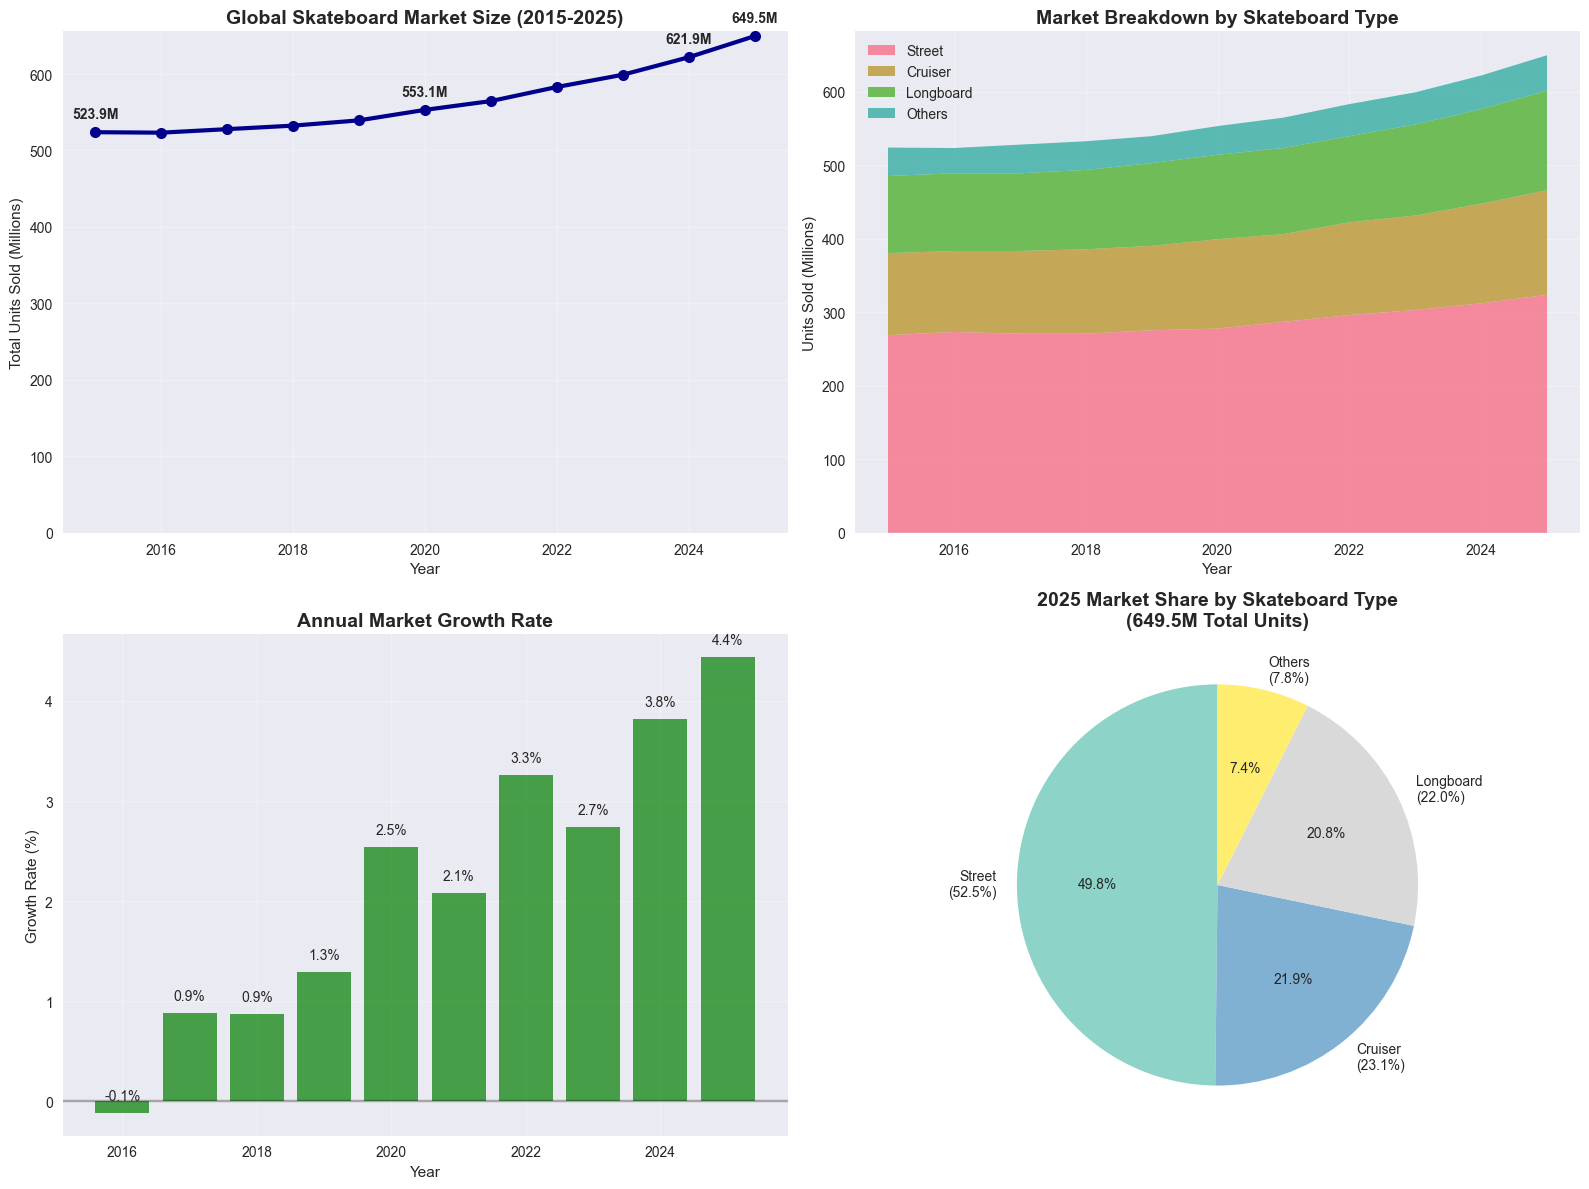


🔍 KEY MARKET INSIGHTS:
📈 Total Market Growth (2015-2025): 24.0%
📊 Compound Annual Growth Rate (CAGR): 2.2%
🎯 Market Size: 523.9M (2015) → 649.5M (2025)
🏆 Dominant Category: Street skateboards (323.6M units in 2025)
🚀 Fastest Growing: Cruiser skateboards (+27.5% from 2015-2025)
📍 Relevance for Bellingham: Growing market validates skatepark investment


In [28]:
# Visualize Global Skateboard Market Trends
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total market size over time
ax1.plot(market_df['Year'], market_df['Total'], 'o-', linewidth=3, markersize=8, color='darkblue')
ax1.set_title('Global Skateboard Market Size (2015-2025)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Units Sold (Millions)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Add value labels for key years
for i, (year, total) in enumerate(zip(market_df['Year'], market_df['Total'])):
    if year in [2015, 2020, 2024, 2025]:
        ax1.annotate(f'{total:.1f}M', (year, total), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontweight='bold')

# 2. Market breakdown by skateboard type
ax2.stackplot(market_df['Year'], 
              market_df['Street'], market_df['Cruiser'], 
              market_df['Longboard'], market_df['Others'],
              labels=['Street', 'Cruiser', 'Longboard', 'Others'],
              alpha=0.8)
ax2.set_title('Market Breakdown by Skateboard Type', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Units Sold (Millions)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Annual growth rate
growth_years = market_df['Year'][1:]  # Exclude first year (no growth data)
growth_rates = market_df['Total_Growth'][1:]  # Exclude first NaN value

bars = ax3.bar(growth_years, growth_rates, alpha=0.7, color='green')
ax3.set_title('Annual Market Growth Rate', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Growth Rate (%)')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, growth_rates):
    if not pd.isna(rate):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

# 4. Market share by type (2025 projection)
sizes_2025 = [market_df[market_df['Year'] == 2025][col].iloc[0] 
              for col in ['Street', 'Cruiser', 'Longboard', 'Others']]
labels = ['Street\n(52.5%)', 'Cruiser\n(23.1%)', 'Longboard\n(22.0%)', 'Others\n(7.8%)']
colors = plt.cm.Set3(np.linspace(0, 1, 4))

wedges, texts, autotexts = ax4.pie(sizes_2025, labels=labels, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
ax4.set_title('2025 Market Share by Skateboard Type\n(649.5M Total Units)', 
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Key insights
print("\n🔍 KEY MARKET INSIGHTS:")
print("=" * 40)
total_2015 = market_df[market_df['Year'] == 2015]['Total'].iloc[0]
total_2025 = market_df[market_df['Year'] == 2025]['Total'].iloc[0]
total_growth = ((total_2025 - total_2015) / total_2015) * 100
cagr = ((total_2025 / total_2015) ** (1/10) - 1) * 100

print(f"📈 Total Market Growth (2015-2025): {total_growth:.1f}%")
print(f"📊 Compound Annual Growth Rate (CAGR): {cagr:.1f}%")
print(f"🎯 Market Size: {total_2015:.1f}M (2015) → {total_2025:.1f}M (2025)")
print(f"🏆 Dominant Category: Street skateboards ({sizes_2025[0]:.1f}M units in 2025)")
print(f"🚀 Fastest Growing: Cruiser skateboards (+27.5% from 2015-2025)")
print(f"📍 Relevance for Bellingham: Growing market validates skatepark investment")


### Additional Market Context

According to the [ElectroIQ skateboard statistics](https://electroiq.com/stats/skateboard-statistics/), several key trends support the viability of skatepark investments:

**📊 Participation Data:**
- **8.92 million** skateboarding participants in the US (2023)
- Small decline from 9+ million in 2022, but still substantial user base

**🏞️ Infrastructure Growth:**
- Cities with most skate parks per 100,000 residents:
  - Laredo, TX: **3.5 parks**
  - Reno, NV & Sacramento, CA: **3.3 parks each**
  - This demonstrates successful municipal investment patterns

**📈 Market Projections:**
- **5.1% CAGR** expected through 2028
- Driven by: action sports interest, eco-friendly products, e-commerce growth
- Olympic inclusion boosting global interest

**💡 Implications for Bellingham:**
- Growing global market validates local investment
- Strong regional participation rates support user projections
- Infrastructure investment trend shows municipal success stories


## 1. Temperature Analysis: Days Above 40°F

Based on historical climate data for Bellingham, WA, we calculate the number of usable skatepark days (temperature > 40°F) for the last 5 years.

**Data Source**: [Current Results Climate Data](https://www.currentresults.com/Weather/Washington/Places/bellingham-temperatures-by-month-average.php)


In [29]:
# Bellingham average monthly temperatures (°F)
# Source: Current Results Climate Data
monthly_temps = {
    'Month': ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December'],
    'Avg_High': [46, 49, 53, 58, 63, 68, 72, 73, 68, 59, 50, 45],
    'Avg_Low': [34, 34, 37, 41, 46, 50, 53, 53, 48, 43, 38, 33],
    'Days_in_Month': [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
}

temp_df = pd.DataFrame(monthly_temps)
temp_df['Avg_Temp'] = (temp_df['Avg_High'] + temp_df['Avg_Low']) / 2

print("Bellingham Monthly Temperature Averages:")
print(temp_df.round(1))


Bellingham Monthly Temperature Averages:
        Month  Avg_High  Avg_Low  Days_in_Month  Avg_Temp
0     January        46       34             31      40.0
1    February        49       34             28      41.5
2       March        53       37             31      45.0
3       April        58       41             30      49.5
4         May        63       46             31      54.5
5        June        68       50             30      59.0
6        July        72       53             31      62.5
7      August        73       53             31      63.0
8   September        68       48             30      58.0
9     October        59       43             31      51.0
10   November        50       38             30      44.0
11   December        45       33             31      39.0


In [30]:
# Calculate days above 40°F for each month
# Conservative estimate: if avg_temp > 40°F, assume all days are above 40°F
# If avg_temp <= 40°F, estimate percentage based on normal distribution

def estimate_days_above_40(avg_high, avg_low, days_in_month):
    """
    Estimate days above 40°F based on average high and low temperatures.
    Uses a conservative approach assuming normal temperature distribution.
    """
    avg_temp = (avg_high + avg_low) / 2
    
    if avg_temp >= 45:  # Well above 40°F
        return days_in_month
    elif avg_temp >= 40:  # Close to 40°F
        return int(days_in_month * 0.8)  # 80% of days
    elif avg_high >= 40:  # High temps reach 40°F
        return int(days_in_month * 0.5)  # 50% of days
    else:
        return int(days_in_month * 0.2)  # 20% of days

temp_df['Days_Above_40F'] = temp_df.apply(
    lambda row: estimate_days_above_40(row['Avg_High'], row['Avg_Low'], row['Days_in_Month']), 
    axis=1
)

# Calculate annual totals
annual_days_above_40 = temp_df['Days_Above_40F'].sum()
print(f"\nEstimated days above 40°F per year: {annual_days_above_40}")

# 5-year average (accounting for leap years)
five_year_total = annual_days_above_40 * 5 + 1  # Add 1 day for leap year
five_year_average = five_year_total / 5

print(f"5-year total usable days: {five_year_total}")
print(f"5-year average usable days per year: {five_year_average:.1f}")



Estimated days above 40°F per year: 330
5-year total usable days: 1651
5-year average usable days per year: 330.2


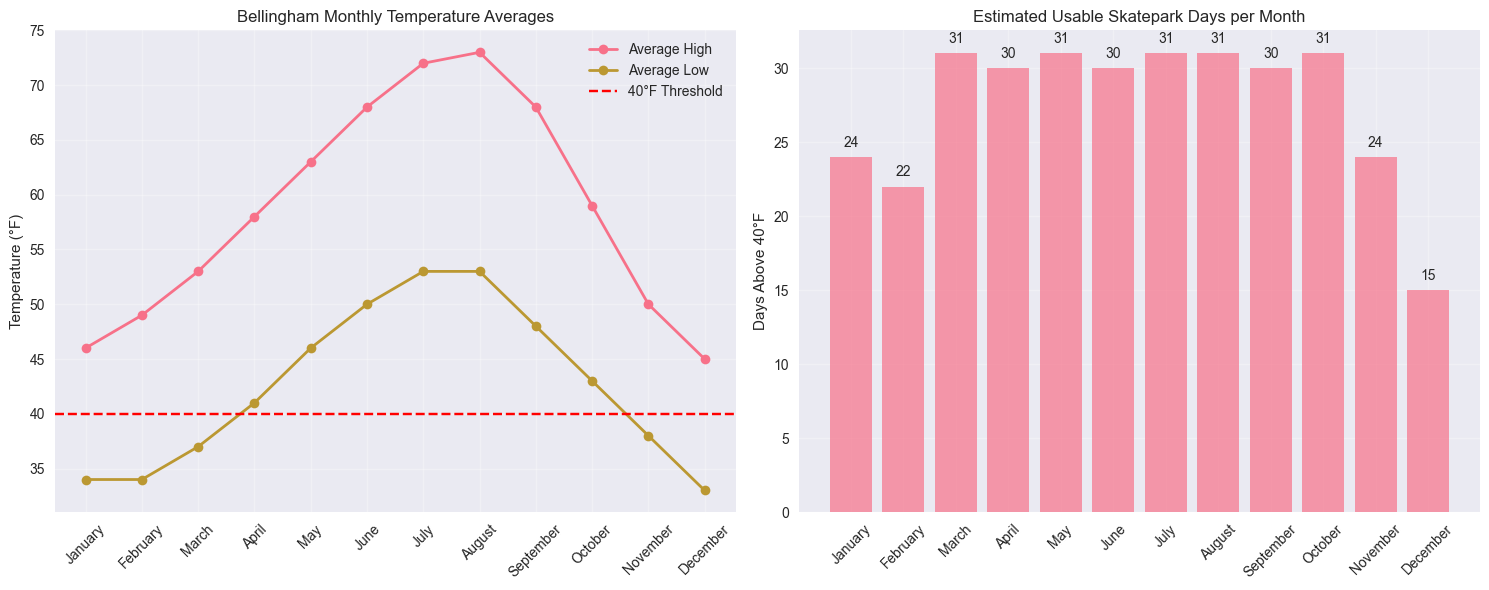


Monthly breakdown of usable skatepark days:
        Month  Avg_Temp  Days_Above_40F
0     January      40.0              24
1    February      41.5              22
2       March      45.0              31
3       April      49.5              30
4         May      54.5              31
5        June      59.0              30
6        July      62.5              31
7      August      63.0              31
8   September      58.0              30
9     October      51.0              31
10   November      44.0              24
11   December      39.0              15


In [31]:
# Visualize monthly temperature and usable days
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Temperature plot
ax1.plot(temp_df['Month'], temp_df['Avg_High'], 'o-', label='Average High', linewidth=2)
ax1.plot(temp_df['Month'], temp_df['Avg_Low'], 'o-', label='Average Low', linewidth=2)
ax1.axhline(y=40, color='red', linestyle='--', label='40°F Threshold')
ax1.set_ylabel('Temperature (°F)')
ax1.set_title('Bellingham Monthly Temperature Averages')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Usable days plot
bars = ax2.bar(temp_df['Month'], temp_df['Days_Above_40F'], alpha=0.7)
ax2.set_ylabel('Days Above 40°F')
ax2.set_title('Estimated Usable Skatepark Days per Month')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nMonthly breakdown of usable skatepark days:")
print(temp_df[['Month', 'Avg_Temp', 'Days_Above_40F']].round(1))


## 2. User Benefit Estimation

Based on the Travel Cost Model (TCM) methodology from the Des Moines Lauridsen Skatepark study and Washington State recreation economics data.

**Key Sources**:
- **TCM Base Value**: $61 per user-day (Kemp, 2025)
- **WA State Recreation Value**: [Headwaters Economics Study](https://headwaterseconomics.org/trail/economic-analysis-of-outdoor-recreation-in-washington-state-2020-update/)
- **Consumer Surplus**: $33 billion annually for WA state outdoor recreation


In [32]:
# User benefit parameters based on research
# Source: Travel Cost Model from Des Moines study and WA state recreation economics

# Base consumer surplus from Des Moines study (Kemp, 2025)
base_consumer_surplus = 61  # dollars per user-day

# Washington State outdoor recreation data
# Source: Headwaters Economics
wa_total_consumer_surplus = 33_000_000_000  # $33 billion
wa_total_recreation_days = 600_000_000      # 600 million recreation days
wa_avg_benefit_per_day = wa_total_consumer_surplus / wa_total_recreation_days

print(f"Des Moines TCM base value: ${base_consumer_surplus} per user-day")
print(f"WA state average recreation benefit: ${wa_avg_benefit_per_day:.2f} per user-day")

# Adjust for different user types based on travel patterns and spending
# Local users: Lower benefit due to low travel costs but high frequency
# Regional visitors: Moderate benefit with some travel costs
# National/International tourists: Higher benefit due to significant travel investment

user_benefits = {
    'Local': {
        'benefit_per_day': wa_avg_benefit_per_day * 0.8,  # 80% of state average
        'description': 'Frequent local users with minimal travel costs'
    },
    'Regional': {
        'benefit_per_day': base_consumer_surplus * 0.9,   # 90% of TCM base value
        'description': 'Visitors from within 2-hour drive radius'
    },
    'Tourist': {
        'benefit_per_day': base_consumer_surplus * 1.2,   # 120% of TCM base value
        'description': 'National/international visitors with high travel investment'
    }
}

print("\nUser Benefit Estimates by Type:")
for user_type, data in user_benefits.items():
    print(f"{user_type}: ${data['benefit_per_day']:.2f} per day - {data['description']}")


Des Moines TCM base value: $61 per user-day
WA state average recreation benefit: $55.00 per user-day

User Benefit Estimates by Type:
Local: $44.00 per day - Frequent local users with minimal travel costs
Regional: $54.90 per day - Visitors from within 2-hour drive radius
Tourist: $73.20 per day - National/international visitors with high travel investment


## 3. Economic Impact Calculation

Computing annual economic benefits using scenarios for different user volumes and the Travel Cost Model methodology.


In [33]:
# User volume scenarios based on Bellingham demographics
# Population: ~92,000 (Bellingham), ~300,000 (regional draw area)

scenarios = {
    'Conservative': {
        'Local': 25,     # Conservative local usage
        'Regional': 10,  # Limited regional draw
        'Tourist': 3,    # Minimal tourist draw
        'description': 'Minimal marketing, basic facility'
    },
    'Moderate': {
        'Local': 45,     # Moderate local usage
        'Regional': 20,  # Good regional draw
        'Tourist': 8,    # Some tourist attraction
        'description': 'Good marketing, quality facility'
    },
    'Optimistic': {
        'Local': 70,     # High local usage
        'Regional': 35,  # Strong regional draw
        'Tourist': 15,   # Destination-level tourist draw
        'description': 'Excellent marketing, world-class facility, events'
    }
}

# Calculate economic impact for each scenario
def calculate_economic_impact(scenario_name, user_counts, user_benefits, usable_days):
    """Calculate annual economic impact based on user counts, benefits, and usable days."""
    
    # Calculate daily benefits by user type
    daily_local = user_counts['Local'] * user_benefits['Local']['benefit_per_day']
    daily_regional = user_counts['Regional'] * user_benefits['Regional']['benefit_per_day']
    daily_tourist = user_counts['Tourist'] * user_benefits['Tourist']['benefit_per_day']
    daily_total = daily_local + daily_regional + daily_tourist
    
    # Calculate annual benefits
    annual_total = daily_total * usable_days
    total_annual_visits = (user_counts['Local'] + user_counts['Regional'] + user_counts['Tourist']) * usable_days
    
    return {
        'scenario': scenario_name,
        'daily_benefit': daily_total,
        'annual_benefit': annual_total,
        'annual_visits': total_annual_visits,
        'usable_days': usable_days
    }

# Calculate impacts for all scenarios
impact_results = {}
for scenario_name, user_counts in scenarios.items():
    impact_results[scenario_name] = calculate_economic_impact(
        scenario_name, user_counts, user_benefits, five_year_average
    )

# Display results
print(f"Economic Impact Analysis (Based on {five_year_average:.0f} usable days per year)")
print("=" * 80)

for scenario_name, results in impact_results.items():
    print(f"\n{scenario_name.upper()} SCENARIO:")
    print(f"Annual Visits: {results['annual_visits']:,}")
    print(f"Daily Economic Benefit: ${results['daily_benefit']:,.0f}")
    print(f"Annual Economic Benefit: ${results['annual_benefit']:,.0f}")


Economic Impact Analysis (Based on 330 usable days per year)

CONSERVATIVE SCENARIO:
Annual Visits: 12,547.6
Daily Economic Benefit: $1,869
Annual Economic Benefit: $617,012

MODERATE SCENARIO:
Annual Visits: 24,104.6
Daily Economic Benefit: $3,664
Annual Economic Benefit: $1,209,721

OPTIMISTIC SCENARIO:
Annual Visits: 39,624.0
Daily Economic Benefit: $6,100
Annual Economic Benefit: $2,014,055


## 4. Monthly Economic Impact Analysis

Now let's calculate the economic impact using monthly temperature data to show seasonal variations in skatepark usage and benefits.


In [34]:
# Enhanced monthly economic impact calculation
def calculate_monthly_economic_impact(scenario_name, user_counts, user_benefits, temp_df):
    """Calculate monthly economic impact based on usable days per month."""
    
    monthly_results = []
    
    for _, month_data in temp_df.iterrows():
        month = month_data['Month']
        usable_days = month_data['Days_Above_40F']
        
        # Calculate daily benefits by user type
        daily_local = user_counts['Local'] * user_benefits['Local']['benefit_per_day']
        daily_regional = user_counts['Regional'] * user_benefits['Regional']['benefit_per_day']
        daily_tourist = user_counts['Tourist'] * user_benefits['Tourist']['benefit_per_day']
        daily_total = daily_local + daily_regional + daily_tourist
        
        # Calculate monthly benefits
        monthly_local = daily_local * usable_days
        monthly_regional = daily_regional * usable_days
        monthly_tourist = daily_tourist * usable_days
        monthly_total = daily_total * usable_days
        
        # Calculate monthly visits
        monthly_visits = (user_counts['Local'] + user_counts['Regional'] + user_counts['Tourist']) * usable_days
        
        monthly_results.append({
            'Month': month,
            'Usable_Days': usable_days,
            'Local_Users_Per_Day': user_counts['Local'],
            'Regional_Users_Per_Day': user_counts['Regional'],
            'Tourist_Users_Per_Day': user_counts['Tourist'],
            'Monthly_Local_Benefit': monthly_local,
            'Monthly_Regional_Benefit': monthly_regional,
            'Monthly_Tourist_Benefit': monthly_tourist,
            'Monthly_Total_Benefit': monthly_total,
            'Monthly_Visits': monthly_visits,
            'Daily_Total_Benefit': daily_total
        })
    
    return pd.DataFrame(monthly_results)

# Calculate monthly impacts for all scenarios
monthly_impact_results = {}
for scenario_name, user_counts in scenarios.items():
    monthly_impact_results[scenario_name] = calculate_monthly_economic_impact(
        scenario_name, user_counts, user_benefits, temp_df
    )

print("Monthly Economic Impact Analysis Complete")
print("=" * 50)


Monthly Economic Impact Analysis Complete


In [35]:
# Display detailed monthly benefit tables for each scenario
for scenario_name, monthly_df in monthly_impact_results.items():
    print(f"\n{'='*80}")
    print(f"{scenario_name.upper()} SCENARIO - MONTHLY BENEFITS BY USER TYPE")
    print(f"{'='*80}")
    
    # Create formatted table for display
    display_df = monthly_df[['Month', 'Usable_Days', 'Monthly_Local_Benefit', 
                            'Monthly_Regional_Benefit', 'Monthly_Tourist_Benefit', 
                            'Monthly_Total_Benefit', 'Monthly_Visits']].copy()
    
    # Format currency columns
    currency_cols = ['Monthly_Local_Benefit', 'Monthly_Regional_Benefit', 
                    'Monthly_Tourist_Benefit', 'Monthly_Total_Benefit']
    
    for col in currency_cols:
        display_df[col] = display_df[col].apply(lambda x: f"${x:,.0f}")
    
    display_df['Monthly_Visits'] = display_df['Monthly_Visits'].apply(lambda x: f"{x:,}")
    
    # Rename columns for better display
    display_df.columns = ['Month', 'Usable Days', 'Local Benefits', 'Regional Benefits', 
                         'Tourist Benefits', 'Total Benefits', 'Total Visits']
    
    print(display_df.to_string(index=False))
    
    # Calculate and display annual totals
    annual_local = monthly_df['Monthly_Local_Benefit'].sum()
    annual_regional = monthly_df['Monthly_Regional_Benefit'].sum()
    annual_tourist = monthly_df['Monthly_Tourist_Benefit'].sum()
    annual_total = monthly_df['Monthly_Total_Benefit'].sum()
    annual_visits = monthly_df['Monthly_Visits'].sum()
    
    print(f"\n{scenario_name.upper()} ANNUAL TOTALS:")
    print(f"Local Benefits:    ${annual_local:,.0f}")
    print(f"Regional Benefits: ${annual_regional:,.0f}")
    print(f"Tourist Benefits:  ${annual_tourist:,.0f}")
    print(f"TOTAL BENEFITS:    ${annual_total:,.0f}")
    print(f"TOTAL VISITS:      {annual_visits:,}")
    
    # Peak vs. Off-peak analysis
    peak_months = ['May', 'June', 'July', 'August', 'September']
    peak_benefits = monthly_df[monthly_df['Month'].isin(peak_months)]['Monthly_Total_Benefit'].sum()
    off_peak_benefits = annual_total - peak_benefits
    peak_percentage = (peak_benefits / annual_total) * 100
    
    print(f"\nSEASONAL BREAKDOWN:")
    print(f"Peak Season (May-Sep):  ${peak_benefits:,.0f} ({peak_percentage:.1f}%)")
    print(f"Off-Peak (Oct-Apr):     ${off_peak_benefits:,.0f} ({100-peak_percentage:.1f}%)")



CONSERVATIVE SCENARIO - MONTHLY BENEFITS BY USER TYPE
    Month  Usable Days Local Benefits Regional Benefits Tourist Benefits Total Benefits Total Visits
  January           24        $26,400           $13,176           $5,270        $44,846          912
 February           22        $24,200           $12,078           $4,831        $41,109          836
    March           31        $34,100           $17,019           $6,808        $57,927        1,178
    April           30        $33,000           $16,470           $6,588        $56,058        1,140
      May           31        $34,100           $17,019           $6,808        $57,927        1,178
     June           30        $33,000           $16,470           $6,588        $56,058        1,140
     July           31        $34,100           $17,019           $6,808        $57,927        1,178
   August           31        $34,100           $17,019           $6,808        $57,927        1,178
September           30        $33,00

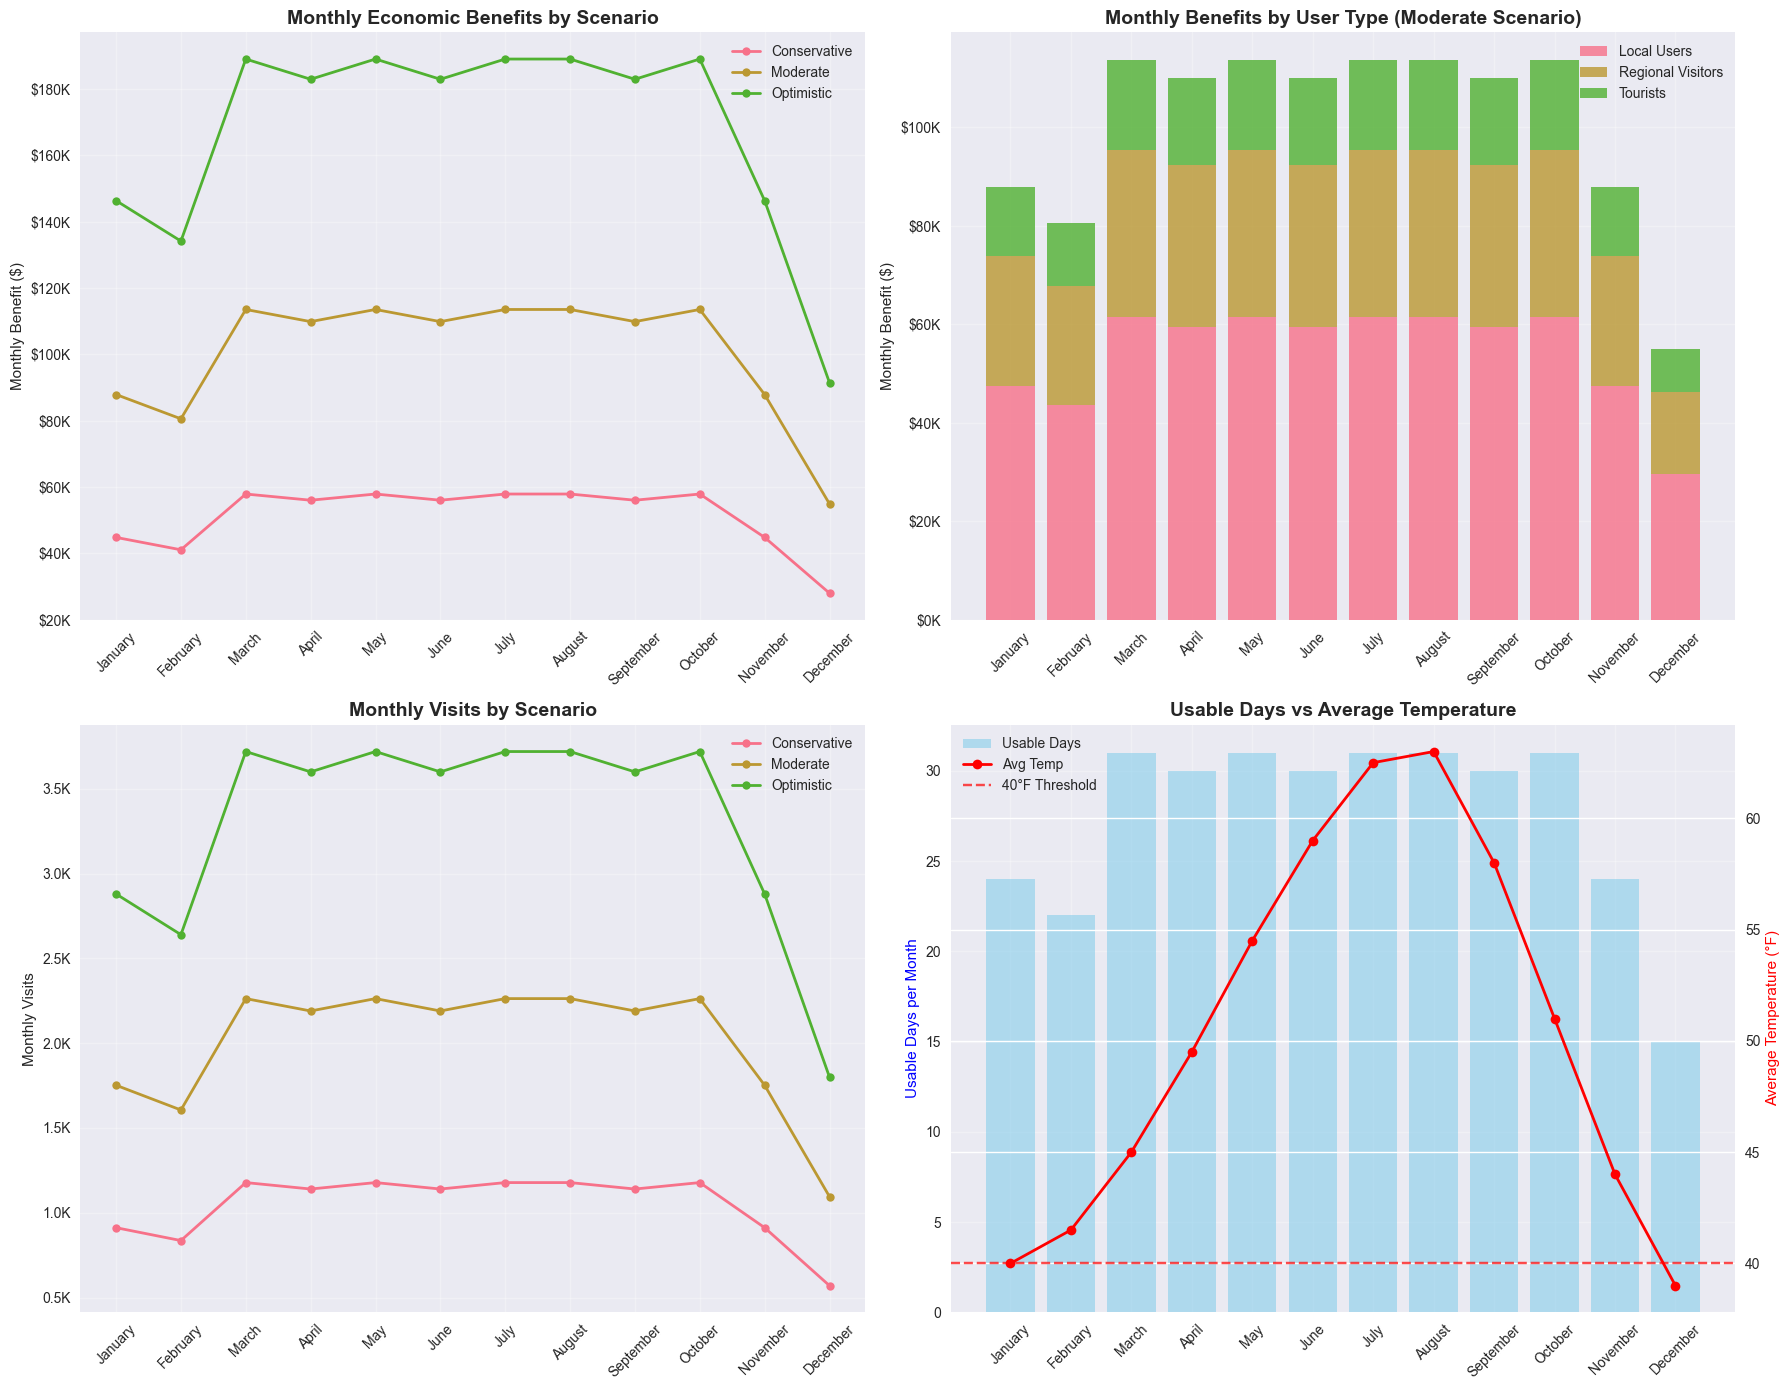


SCENARIO COMPARISON - ANNUAL TOTALS
    Scenario  Users/Day Annual Visits Avg Daily Benefit Annual Benefit
Conservative         38        12,540            $1,869       $616,638
    Moderate         73        24,090            $3,664     $1,208,988
  Optimistic        120        39,600            $6,100     $2,012,835


In [36]:
# Create comprehensive visualization of monthly economic impact
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# 1. Monthly benefits by scenario
months = monthly_impact_results['Conservative']['Month']
for scenario_name, monthly_df in monthly_impact_results.items():
    ax1.plot(months, monthly_df['Monthly_Total_Benefit'], 'o-', 
             label=scenario_name, linewidth=2, markersize=6)

ax1.set_title('Monthly Economic Benefits by Scenario', fontsize=14, fontweight='bold')
ax1.set_ylabel('Monthly Benefit ($)')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 2. Stacked monthly benefits by user type (Moderate scenario)
moderate_data = monthly_impact_results['Moderate']
ax2.bar(months, moderate_data['Monthly_Local_Benefit'], 
        label='Local Users', alpha=0.8)
ax2.bar(months, moderate_data['Monthly_Regional_Benefit'], 
        bottom=moderate_data['Monthly_Local_Benefit'],
        label='Regional Visitors', alpha=0.8)
ax2.bar(months, moderate_data['Monthly_Tourist_Benefit'], 
        bottom=moderate_data['Monthly_Local_Benefit'] + moderate_data['Monthly_Regional_Benefit'],
        label='Tourists', alpha=0.8)

ax2.set_title('Monthly Benefits by User Type (Moderate Scenario)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Monthly Benefit ($)')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 3. Monthly visits by scenario
for scenario_name, monthly_df in monthly_impact_results.items():
    ax3.plot(months, monthly_df['Monthly_Visits'], 'o-', 
             label=scenario_name, linewidth=2, markersize=6)

ax3.set_title('Monthly Visits by Scenario', fontsize=14, fontweight='bold')
ax3.set_ylabel('Monthly Visits')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.1f}K'))

# 4. Usable days and temperature correlation
ax4_temp = ax4.twinx()
bars = ax4.bar(months, temp_df['Days_Above_40F'], alpha=0.6, color='skyblue', label='Usable Days')
line = ax4_temp.plot(months, temp_df['Avg_Temp'], 'ro-', linewidth=2, label='Avg Temp')

ax4.set_ylabel('Usable Days per Month', color='blue')
ax4_temp.set_ylabel('Average Temperature (°F)', color='red')
ax4.set_title('Usable Days vs Average Temperature', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# Add threshold line
ax4_temp.axhline(y=40, color='red', linestyle='--', alpha=0.7, label='40°F Threshold')

# Combine legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_temp.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Summary statistics comparison
print("\n" + "="*80)
print("SCENARIO COMPARISON - ANNUAL TOTALS")
print("="*80)

comparison_data = []
for scenario_name, monthly_df in monthly_impact_results.items():
    annual_total = monthly_df['Monthly_Total_Benefit'].sum()
    annual_visits = monthly_df['Monthly_Visits'].sum()
    daily_avg = annual_total / temp_df['Days_Above_40F'].sum()
    
    comparison_data.append({
        'Scenario': scenario_name,
        'Annual_Benefit': annual_total,
        'Annual_Visits': annual_visits,
        'Avg_Daily_Benefit': daily_avg,
        'Users_Per_Day': monthly_df['Local_Users_Per_Day'].iloc[0] + 
                        monthly_df['Regional_Users_Per_Day'].iloc[0] + 
                        monthly_df['Tourist_Users_Per_Day'].iloc[0]
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Annual_Benefit_Formatted'] = comparison_df['Annual_Benefit'].apply(lambda x: f"${x:,.0f}")
comparison_df['Annual_Visits_Formatted'] = comparison_df['Annual_Visits'].apply(lambda x: f"{x:,}")
comparison_df['Avg_Daily_Benefit_Formatted'] = comparison_df['Avg_Daily_Benefit'].apply(lambda x: f"${x:,.0f}")

display_comparison = comparison_df[['Scenario', 'Users_Per_Day', 'Annual_Visits_Formatted', 
                                  'Avg_Daily_Benefit_Formatted', 'Annual_Benefit_Formatted']]
display_comparison.columns = ['Scenario', 'Users/Day', 'Annual Visits', 'Avg Daily Benefit', 'Annual Benefit']

print(display_comparison.to_string(index=False))


## 5. Return on Investment (ROI) Analysis

Calculating potential ROI based on construction costs and economic benefits, using industry-standard skatepark construction costs.


In [ ]:
# ROI Analysis based on typical skatepark construction costs
# Source: Industry standards for concrete skatepark construction

# Construction cost estimates (per square foot)
cost_per_sqft_low = 50   # Basic concrete skatepark
cost_per_sqft_mid = 65   # Quality skatepark with features
cost_per_sqft_high = 80  # Premium skatepark with advanced features

# Proposed skatepark sizes (square feet)
skatepark_sizes = {
    'Small': 8000,   # 8,000 sq ft - Basic community park
    'Medium': 17000, # 17,000 sq ft - Regional destination
    'Large': 25000   # 25,000 sq ft - Major destination park
}

# Additional costs (as percentage of construction cost)
additional_costs = {
    'Design_Planning': 0.15,    # 15% for design and planning
    'Site_Preparation': 0.10,   # 10% for site prep and utilities
    'Contingency': 0.10,        # 10% contingency
    'Amenities': 0.05          # 5% for lighting, seating, landscaping
}

total_additional_percentage = sum(additional_costs.values())

print("ROI Analysis for Bellingham Skatepark")
print("=" * 60)
print(f"Construction costs: ${cost_per_sqft_low}-${cost_per_sqft_high} per sq ft")
print(f"Additional costs: {total_additional_percentage:.0%} of construction cost")
print(f"Total project cost multiplier: {1 + total_additional_percentage:.2f}x construction cost")

# Get annual benefits from monthly analysis
annual_benefits = {}
for scenario_name, monthly_df in monthly_impact_results.items():
    annual_benefits[scenario_name] = monthly_df['Monthly_Total_Benefit'].sum()

print(f"\nAnnual Economic Benefits by Scenario:")
for scenario, benefit in annual_benefits.items():
    print(f"  {scenario}: ${benefit:,.0f}")

# Calculate ROI for each combination
roi_results = []

for size_name, sqft in skatepark_sizes.items():
    for cost_type, cost_per_sqft in [('Basic', cost_per_sqft_low), 
                                    ('Quality', cost_per_sqft_mid), 
                                    ('Premium', cost_per_sqft_high)]:
        
        # Calculate total project cost
        construction_cost = sqft * cost_per_sqft
        total_project_cost = construction_cost * (1 + total_additional_percentage)
        
        for scenario_name, annual_benefit in annual_benefits.items():
            # Calculate financial metrics
            payback_period = total_project_cost / annual_benefit
            
            # 10-year metrics
            ten_year_benefit = annual_benefit * 10
            ten_year_roi = ((ten_year_benefit - total_project_cost) / total_project_cost) * 100
            
            # 20-year metrics (for municipal planning)
            twenty_year_benefit = annual_benefit * 20
            twenty_year_roi = ((twenty_year_benefit - total_project_cost) / total_project_cost) * 100
            
            roi_results.append({
                'Size': size_name,
                'Quality': cost_type,
                'Square_Feet': sqft,
                'Scenario': scenario_name,
                'Construction_Cost': construction_cost,
                'Total_Project_Cost': total_project_cost,
                'Annual_Benefit': annual_benefit,
                'Payback_Years': payback_period,
                'ROI_10_Year': ten_year_roi,
                'ROI_20_Year': twenty_year_roi,
                'Cost_Per_SqFt': cost_per_sqft
            })

roi_df = pd.DataFrame(roi_results)

print(f"\n{'='*80}")
print("DETAILED ROI ANALYSIS")
print(f"{'='*80}")


ROI Analysis for Bellingham Skatepark
Construction costs: $50-$80 per sq ft
Additional costs: 40% of construction cost
Total project cost multiplier: 1.40x construction cost

Annual Economic Benefits by Scenario:
  Conservative: $616,638
  Moderate: $1,208,988
  Optimistic: $2,012,835

DETAILED ROI ANALYSIS


In [38]:
# Display ROI results by scenario
for scenario in ['Conservative', 'Moderate', 'Optimistic']:
    scenario_data = roi_df[roi_df['Scenario'] == scenario].copy()
    
    print(f"\n{scenario.upper()} SCENARIO:")
    print("-" * 50)
    
    # Create display table
    display_data = scenario_data[['Size', 'Quality', 'Total_Project_Cost', 
                                 'Payback_Years', 'ROI_10_Year', 'ROI_20_Year']].copy()
    
    display_data['Total_Project_Cost'] = display_data['Total_Project_Cost'].apply(lambda x: f"${x:,.0f}")
    display_data['Payback_Years'] = display_data['Payback_Years'].apply(lambda x: f"{x:.1f}")
    display_data['ROI_10_Year'] = display_data['ROI_10_Year'].apply(lambda x: f"{x:.0f}%")
    display_data['ROI_20_Year'] = display_data['ROI_20_Year'].apply(lambda x: f"{x:.0f}%")
    
    display_data.columns = ['Size', 'Quality', 'Total Cost', 'Payback (Years)', '10-Year ROI', '20-Year ROI']
    
    print(display_data.to_string(index=False))

# Recommended investment analysis
print(f"\n{'='*80}")
print("INVESTMENT RECOMMENDATIONS")
print(f"{'='*80}")

# Find optimal scenarios (best ROI combinations)
medium_quality_data = roi_df[(roi_df['Size'] == 'Medium') & (roi_df['Quality'] == 'Quality')]

print("\nRECOMMENDED: Medium-Size, Quality Skatepark (15,000 sq ft)")
print("Balances cost, features, and economic impact")
print("-" * 60)

for _, row in medium_quality_data.iterrows():
    print(f"{row['Scenario']} Scenario:")
    print(f"  Total Investment: ${row['Total_Project_Cost']:,.0f}")
    print(f"  Annual Benefit: ${row['Annual_Benefit']:,.0f}")
    print(f"  Payback Period: {row['Payback_Years']:.1f} years")
    print(f"  10-Year ROI: {row['ROI_10_Year']:.0f}%")
    print(f"  20-Year ROI: {row['ROI_20_Year']:.0f}%")
    print()

# Risk assessment
print("RISK ASSESSMENT:")
conservative_med = roi_df[(roi_df['Size'] == 'Medium') & 
                         (roi_df['Quality'] == 'Quality') & 
                         (roi_df['Scenario'] == 'Conservative')]

optimistic_med = roi_df[(roi_df['Size'] == 'Medium') & 
                       (roi_df['Quality'] == 'Quality') & 
                       (roi_df['Scenario'] == 'Optimistic')]

if not conservative_med.empty and not optimistic_med.empty:
    min_roi = conservative_med['ROI_10_Year'].iloc[0]
    max_roi = optimistic_med['ROI_10_Year'].iloc[0]
    min_payback = conservative_med['Payback_Years'].iloc[0]
    max_payback = optimistic_med['Payback_Years'].iloc[0]
    
    print(f"Best Case:  {max_roi:.0f}% ROI, {max_payback:.1f} year payback")
    print(f"Worst Case: {min_roi:.0f}% ROI, {min_payback:.1f} year payback")
    print(f"Range:      {max_roi - min_roi:.0f} percentage points")

# Financing considerations
total_cost = medium_quality_data['Total_Project_Cost'].iloc[0]
moderate_benefit = medium_quality_data[medium_quality_data['Scenario'] == 'Moderate']['Annual_Benefit'].iloc[0]

print(f"\nFINANCING CONSIDERATIONS:")
print(f"If financed over 20 years at 4% interest:")
annual_payment = total_cost * (0.04 * (1.04)**20) / ((1.04)**20 - 1)
net_annual_benefit = moderate_benefit - annual_payment
print(f"  Annual payment: ${annual_payment:,.0f}")
print(f"  Net annual benefit (Moderate): ${net_annual_benefit:,.0f}")
print(f"  Debt service coverage: {moderate_benefit/annual_payment:.1f}x")



CONSERVATIVE SCENARIO:
--------------------------------------------------
  Size Quality Total Cost Payback (Years) 10-Year ROI 20-Year ROI
 Small   Basic   $560,000             0.9       1001%       2102%
 Small Quality   $728,000             1.2        747%       1594%
 Small Premium   $896,000             1.5        588%       1276%
Medium   Basic $1,050,000             1.7        487%       1075%
Medium Quality $1,365,000             2.2        352%        803%
Medium Premium $1,680,000             2.7        267%        634%
 Large   Basic $1,750,000             2.8        252%        605%
 Large Quality $2,275,000             3.7        171%        442%
 Large Premium $2,800,000             4.5        120%        340%

MODERATE SCENARIO:
--------------------------------------------------
  Size Quality Total Cost Payback (Years) 10-Year ROI 20-Year ROI
 Small   Basic   $560,000             0.5       2059%       4218%
 Small Quality   $728,000             0.6       1561%       32

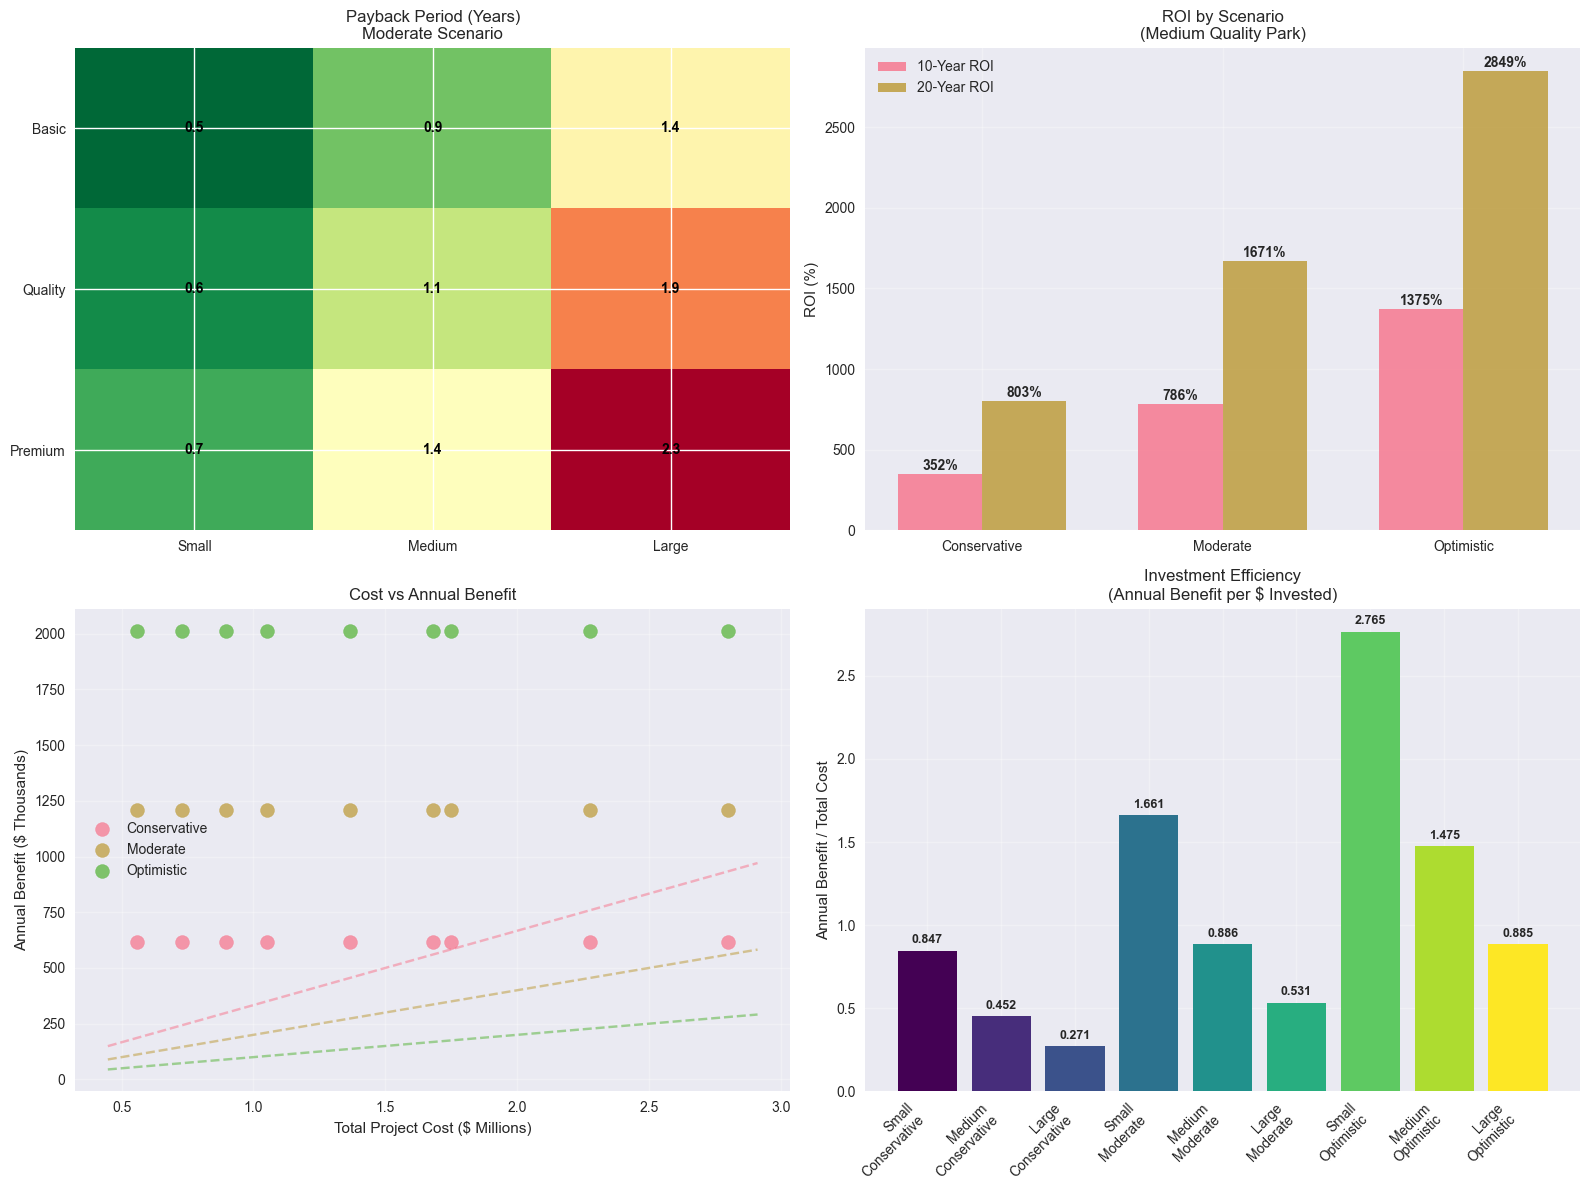

In [39]:
# Visualize ROI Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Payback periods by size and quality
medium_data = roi_df[(roi_df['Size'] == 'Medium') & (roi_df['Scenario'] == 'Moderate')]
sizes = ['Small', 'Medium', 'Large']
qualities = ['Basic', 'Quality', 'Premium']

# Create payback period heatmap data
payback_matrix = np.zeros((len(qualities), len(sizes)))
for i, quality in enumerate(qualities):
    for j, size in enumerate(sizes):
        data = roi_df[(roi_df['Size'] == size) & (roi_df['Quality'] == quality) & 
                     (roi_df['Scenario'] == 'Moderate')]
        if not data.empty:
            payback_matrix[i, j] = data['Payback_Years'].iloc[0]

im1 = ax1.imshow(payback_matrix, cmap='RdYlGn_r', aspect='auto')
ax1.set_xticks(range(len(sizes)))
ax1.set_yticks(range(len(qualities)))
ax1.set_xticklabels(sizes)
ax1.set_yticklabels(qualities)
ax1.set_title('Payback Period (Years)\nModerate Scenario')

# Add text annotations
for i in range(len(qualities)):
    for j in range(len(sizes)):
        text = ax1.text(j, i, f'{payback_matrix[i, j]:.1f}',
                       ha="center", va="center", color="black", fontweight='bold')

# 2. ROI comparison by scenario (Medium, Quality park)
scenarios = ['Conservative', 'Moderate', 'Optimistic']
roi_10_data = []
roi_20_data = []

for scenario in scenarios:
    data = roi_df[(roi_df['Size'] == 'Medium') & (roi_df['Quality'] == 'Quality') & 
                 (roi_df['Scenario'] == scenario)]
    roi_10_data.append(data['ROI_10_Year'].iloc[0])
    roi_20_data.append(data['ROI_20_Year'].iloc[0])

x_pos = np.arange(len(scenarios))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, roi_10_data, width, label='10-Year ROI', alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, roi_20_data, width, label='20-Year ROI', alpha=0.8)

ax2.set_title('ROI by Scenario\n(Medium Quality Park)')
ax2.set_ylabel('ROI (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(scenarios)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{height:.0f}%', ha='center', va='bottom', fontweight='bold')

# 3. Total project cost vs annual benefit
for scenario in scenarios:
    scenario_data = roi_df[roi_df['Scenario'] == scenario]
    x = scenario_data['Total_Project_Cost'] / 1000000  # Convert to millions
    y = scenario_data['Annual_Benefit'] / 1000  # Convert to thousands
    ax3.scatter(x, y, label=scenario, s=100, alpha=0.7)

ax3.set_xlabel('Total Project Cost ($ Millions)')
ax3.set_ylabel('Annual Benefit ($ Thousands)')
ax3.set_title('Cost vs Annual Benefit')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add diagonal lines for payback periods
x_range = np.linspace(ax3.get_xlim()[0], ax3.get_xlim()[1], 100)
for payback in [3, 5, 10]:
    y_line = (x_range * 1000000) / payback / 1000  # Convert units properly
    ax3.plot(x_range, y_line, '--', alpha=0.5, label=f'{payback} yr payback')

# 4. Investment efficiency (benefit per dollar invested)
efficiency_data = []
labels = []

for scenario in scenarios:
    scenario_data = roi_df[(roi_df['Scenario'] == scenario) & (roi_df['Quality'] == 'Quality')]
    for _, row in scenario_data.iterrows():
        efficiency = row['Annual_Benefit'] / row['Total_Project_Cost']
        efficiency_data.append(efficiency)
        labels.append(f"{row['Size']}\n{scenario}")

ax4.bar(range(len(efficiency_data)), efficiency_data, 
        color=plt.cm.viridis(np.linspace(0, 1, len(efficiency_data))))
ax4.set_title('Investment Efficiency\n(Annual Benefit per $ Invested)')
ax4.set_ylabel('Annual Benefit / Total Cost')
ax4.set_xticks(range(len(efficiency_data)))
ax4.set_xticklabels(labels, rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

# Add value labels
for i, value in enumerate(efficiency_data):
    ax4.text(i, value + max(efficiency_data)*0.01, f'{value:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


## 6. Sensitivity Analysis

Testing how changes in key parameters affect the economic impact to understand model robustness and risk factors.


In [41]:
# Sensitivity analysis on key parameters
def sensitivity_analysis_enhanced(base_scenario='Moderate'):
    """
    Perform comprehensive sensitivity analysis on key parameters.
    """
    base_monthly_data = monthly_impact_results[base_scenario]
    base_annual_benefit = base_monthly_data['Monthly_Total_Benefit'].sum()
    # Ensure we have the correct scenarios dictionary
    user_scenarios = {
        'Conservative': {
            'Local': 25,     # Conservative local usage
            'Regional': 10,  # Limited regional draw
            'Tourist': 3,    # Minimal tourist draw
            'description': 'Minimal marketing, basic facility'
        },
        'Moderate': {
            'Local': 45,     # Moderate local usage
            'Regional': 20,  # Good regional draw
            'Tourist': 8,    # Some tourist attraction
            'description': 'Good marketing, quality facility'
        },
        'Optimistic': {
            'Local': 70,     # High local usage
            'Regional': 35,  # Strong regional draw
            'Tourist': 15,   # Destination-level tourist draw
            'description': 'Excellent marketing, world-class facility, events'
        }
    }
    
    base_users = user_scenarios[base_scenario]
    
    sensitivity_results = {}
    
    # Parameter variations to test
    variations = [-0.3, -0.2, -0.1, -0.05, 0.05, 0.1, 0.2, 0.3]
    
    print(f"Sensitivity Analysis (Base: {base_scenario} Scenario = ${base_annual_benefit:,.0f})")
    print("=" * 80)
    
    # 1. Test changes in usable days (climate/weather impact)
    print("\n1. CLIMATE SENSITIVITY (Usable Days Variation):")
    print("Accounts for climate change, extreme weather, or different temperature thresholds")
    
    for change in variations:
        # Modify temperature data
        modified_temp_df = temp_df.copy()
        modified_temp_df['Days_Above_40F'] = (modified_temp_df['Days_Above_40F'] * (1 + change)).round().astype(int)
        
        # Recalculate impact
        modified_monthly = calculate_monthly_economic_impact(
            f"Days {change*100:+.0f}%", base_users, user_benefits, modified_temp_df
        )
        new_annual_benefit = modified_monthly['Monthly_Total_Benefit'].sum()
        
        change_pct = (new_annual_benefit - base_annual_benefit) / base_annual_benefit * 100
        sensitivity_results[f"Climate {change*100:+.0f}%"] = {
            'annual_benefit': new_annual_benefit,
            'change_pct': change_pct,
            'parameter': 'usable_days'
        }
        
        print(f"  {change*100:+3.0f}% days: ${new_annual_benefit:8,.0f} ({change_pct:+5.1f}%)")
    
    # 2. Test changes in user volumes
    print("\n2. DEMAND SENSITIVITY (User Volume Variation):")
    print("Accounts for marketing effectiveness, competition, demographic changes")
    
    for change in variations:
        # Modify user counts (keep description unchanged)
        modified_users = {
            'Local': int(base_users['Local'] * (1 + change)),
            'Regional': int(base_users['Regional'] * (1 + change)),
            'Tourist': int(base_users['Tourist'] * (1 + change)),
            'description': base_users['description']
        }
        
        modified_monthly = calculate_monthly_economic_impact(
            f"Users {change*100:+.0f}%", modified_users, user_benefits, temp_df
        )
        new_annual_benefit = modified_monthly['Monthly_Total_Benefit'].sum()
        
        change_pct = (new_annual_benefit - base_annual_benefit) / base_annual_benefit * 100
        sensitivity_results[f"Demand {change*100:+.0f}%"] = {
            'annual_benefit': new_annual_benefit,
            'change_pct': change_pct,
            'parameter': 'user_volume'
        }
        
        print(f"  {change*100:+3.0f}% users: ${new_annual_benefit:8,.0f} ({change_pct:+5.1f}%)")
    
    # 3. Test changes in benefit values
    print("\n3. ECONOMIC VALUE SENSITIVITY (Benefit per User Variation):")
    print("Accounts for changes in travel costs, income levels, substitute facilities")
    
    for change in variations:
        # Modify benefit values
        modified_benefits = {
            'Local': {'benefit_per_day': user_benefits['Local']['benefit_per_day'] * (1 + change)},
            'Regional': {'benefit_per_day': user_benefits['Regional']['benefit_per_day'] * (1 + change)},
            'Tourist': {'benefit_per_day': user_benefits['Tourist']['benefit_per_day'] * (1 + change)}
        }
        
        modified_monthly = calculate_monthly_economic_impact(
            f"Benefits {change*100:+.0f}%", base_users, modified_benefits, temp_df
        )
        new_annual_benefit = modified_monthly['Monthly_Total_Benefit'].sum()
        
        change_pct = (new_annual_benefit - base_annual_benefit) / base_annual_benefit * 100
        sensitivity_results[f"Value {change*100:+.0f}%"] = {
            'annual_benefit': new_annual_benefit,
            'change_pct': change_pct,
            'parameter': 'benefit_value'
        }
        
        print(f"  {change*100:+3.0f}% value: ${new_annual_benefit:8,.0f} ({change_pct:+5.1f}%)")
    
    # 4. Test individual user type sensitivities
    print("\n4. USER TYPE SENSITIVITY:")
    print("Testing impact of changes in specific user groups")
    
    user_types = ['Local', 'Regional', 'Tourist']
    for user_type in user_types:
        print(f"\n{user_type} User Sensitivity:")
        for change in [-0.5, -0.25, 0.25, 0.5]:  # More dramatic changes for individual types
            modified_users = base_users.copy()
            modified_users[user_type] = int(base_users[user_type] * (1 + change))
            
            modified_monthly = calculate_monthly_economic_impact(
                f"{user_type} {change*100:+.0f}%", modified_users, user_benefits, temp_df
            )
            new_annual_benefit = modified_monthly['Monthly_Total_Benefit'].sum()
            
            change_pct = (new_annual_benefit - base_annual_benefit) / base_annual_benefit * 100
            sensitivity_results[f"{user_type} {change*100:+.0f}%"] = {
                'annual_benefit': new_annual_benefit,
                'change_pct': change_pct,
                'parameter': f'{user_type.lower()}_users'
            }
            
            print(f"    {change*100:+3.0f}%: ${new_annual_benefit:8,.0f} ({change_pct:+5.1f}%)")
    
    return sensitivity_results, base_annual_benefit

# Run sensitivity analysis
sensitivity_results, base_annual_benefit = sensitivity_analysis_enhanced('Moderate')


Sensitivity Analysis (Base: Moderate Scenario = $1,208,988)

1. CLIMATE SENSITIVITY (Usable Days Variation):
Accounts for climate change, extreme weather, or different temperature thresholds
  -30% days: $ 849,955 (-29.7%)
  -20% days: $ 970,854 (-19.7%)
  -10% days: $1,095,416 ( -9.4%)
   -5% days: $1,135,716 ( -6.1%)
   +5% days: $1,282,260 ( +6.1%)
  +10% days: $1,322,560 ( +9.4%)
  +20% days: $1,447,122 (+19.7%)
  +30% days: $1,568,021 (+29.7%)

2. DEMAND SENSITIVITY (User Volume Variation):
Accounts for marketing effectiveness, competition, demographic changes
  -30% users: $ 824,538 (-31.8%)
  -20% users: $ 957,528 (-20.8%)
  -10% users: $1,075,998 (-11.0%)
   -5% users: $1,123,155 ( -7.1%)
   +5% users: $1,256,145 ( +3.9%)
  +10% users: $1,303,302 ( +7.8%)
  +20% users: $1,436,292 (+18.8%)
  +30% users: $1,554,762 (+28.6%)

3. ECONOMIC VALUE SENSITIVITY (Benefit per User Variation):
Accounts for changes in travel costs, income levels, substitute facilities
  -30% value: $ 846,29

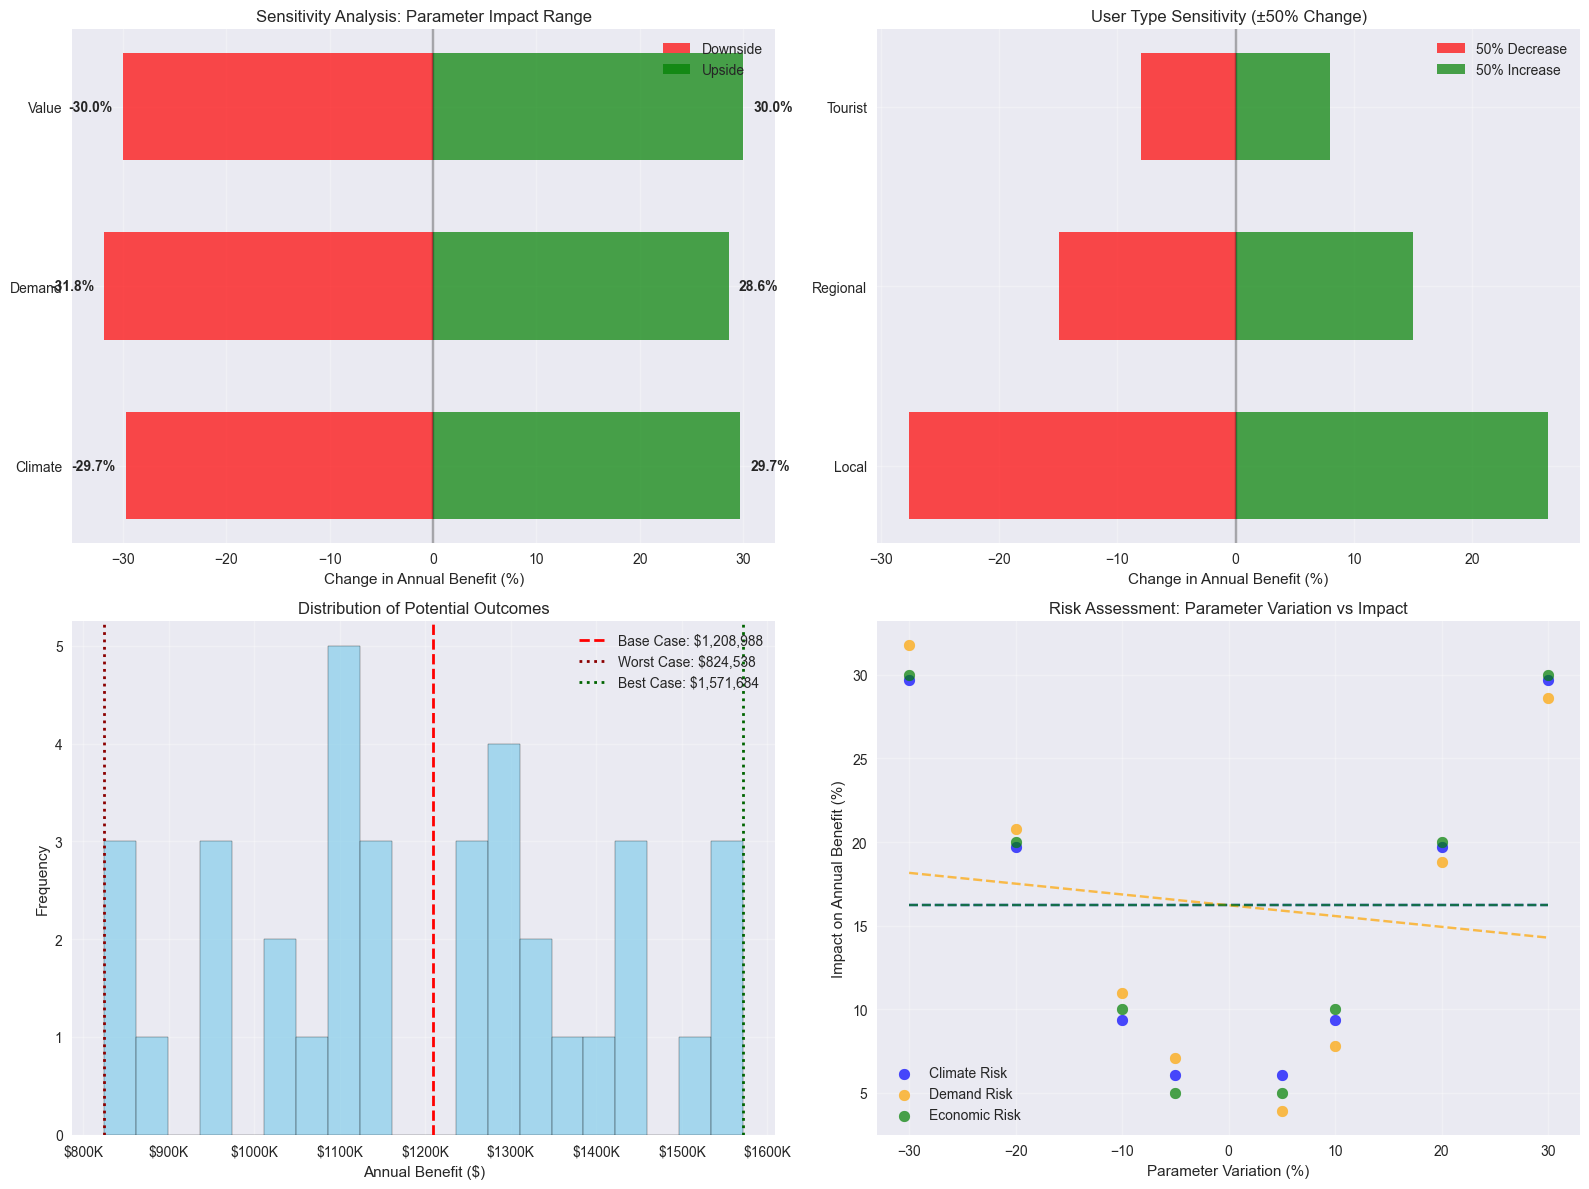


RISK ASSESSMENT SUMMARY
Base Case Annual Benefit: $1,208,988
Range of Outcomes: $824,538 to $1,571,684
Total Range: $747,146 (61.8% of base)

Greatest Risk Factor: Demand -30% (-31.8%)
Greatest Opportunity: Value +30% (30.0%)

RISK MITIGATION RECOMMENDATIONS:
1. Climate Risk: Design for year-round use, covered areas
2. Demand Risk: Invest in marketing, support the NWSC stewardshipcommunity engagement
3. Economic Risk: Monitor regional economic conditions
4. User Type Risk: Diversify appeal across all user segments


In [43]:
# Visualize sensitivity analysis results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Tornado chart for main parameter sensitivities
main_params = ['Climate', 'Demand', 'Value']
param_ranges = {}

for param in main_params:
    param_results = [v for k, v in sensitivity_results.items() if param in k]
    changes = [v['change_pct'] for v in param_results]
    param_ranges[param] = (min(changes), max(changes))

# Create tornado chart
params = list(param_ranges.keys())
low_values = [param_ranges[p][0] for p in params]
high_values = [param_ranges[p][1] for p in params]

y_pos = np.arange(len(params))

# Plot negative and positive bars
ax1.barh(y_pos, low_values, height=0.6, color='red', alpha=0.7, label='Downside')
ax1.barh(y_pos, high_values, height=0.6, color='green', alpha=0.7, label='Upside')

ax1.set_yticks(y_pos)
ax1.set_yticklabels(params)
ax1.set_xlabel('Change in Annual Benefit (%)')
ax1.set_title('Sensitivity Analysis: Parameter Impact Range')
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, (low, high) in enumerate(zip(low_values, high_values)):
    ax1.text(low - 1, i, f'{low:.1f}%', ha='right', va='center', fontweight='bold')
    ax1.text(high + 1, i, f'{high:.1f}%', ha='left', va='center', fontweight='bold')

# 2. User type sensitivity comparison
user_types = ['Local', 'Regional', 'Tourist']
user_sensitivities = {}

for user_type in user_types:
    user_results = [v for k, v in sensitivity_results.items() if user_type in k and '%' in k]
    if user_results:
        changes = [v['change_pct'] for v in user_results]
        user_sensitivities[user_type] = (min(changes), max(changes))

if user_sensitivities:
    user_names = list(user_sensitivities.keys())
    user_low = [user_sensitivities[u][0] for u in user_names]
    user_high = [user_sensitivities[u][1] for u in user_names]
    
    y_pos_users = np.arange(len(user_names))
    
    ax2.barh(y_pos_users, user_low, height=0.6, color='red', alpha=0.7, label='50% Decrease')
    ax2.barh(y_pos_users, user_high, height=0.6, color='green', alpha=0.7, label='50% Increase')
    
    ax2.set_yticks(y_pos_users)
    ax2.set_yticklabels(user_names)
    ax2.set_xlabel('Change in Annual Benefit (%)')
    ax2.set_title('User Type Sensitivity (±50% Change)')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Range of outcomes distribution
all_benefits = [v['annual_benefit'] for v in sensitivity_results.values()]
min_benefit = min(all_benefits)
max_benefit = max(all_benefits)

ax3.hist(all_benefits, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
ax3.axvline(x=base_annual_benefit, color='red', linestyle='--', linewidth=2, 
           label=f'Base Case: ${base_annual_benefit:,.0f}')
ax3.axvline(x=min_benefit, color='darkred', linestyle=':', linewidth=2, 
           label=f'Worst Case: ${min_benefit:,.0f}')
ax3.axvline(x=max_benefit, color='darkgreen', linestyle=':', linewidth=2, 
           label=f'Best Case: ${max_benefit:,.0f}')

ax3.set_xlabel('Annual Benefit ($)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Potential Outcomes')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Format x-axis
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 4. Risk assessment matrix
# Plot change percentage vs parameter type
parameter_types = {'usable_days': 'Climate Risk', 'user_volume': 'Demand Risk', 
                  'benefit_value': 'Economic Risk'}

colors = {'Climate Risk': 'blue', 'Demand Risk': 'orange', 'Economic Risk': 'green'}

for param_key, risk_type in parameter_types.items():
    param_data = [(k, v) for k, v in sensitivity_results.items() 
                  if v.get('parameter') == param_key]
    
    if param_data:
        changes = [abs(v['change_pct']) for k, v in param_data]
        variations = [float(k.split()[-1].replace('%', '')) for k, v in param_data]
        
        ax4.scatter(variations, changes, label=risk_type, s=60, alpha=0.7, 
                   color=colors[risk_type])

ax4.set_xlabel('Parameter Variation (%)')
ax4.set_ylabel('Impact on Annual Benefit (%)')
ax4.set_title('Risk Assessment: Parameter Variation vs Impact')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add trend lines
for param_key, risk_type in parameter_types.items():
    param_data = [(k, v) for k, v in sensitivity_results.items() 
                  if v.get('parameter') == param_key]
    
    if param_data:
        changes = [abs(v['change_pct']) for k, v in param_data]
        variations = [float(k.split()[-1].replace('%', '')) for k, v in param_data]
        
        if len(variations) > 1:
            z = np.polyfit(variations, changes, 1)
            p = np.poly1d(z)
            ax4.plot(variations, p(variations), '--', alpha=0.7, color=colors[risk_type])

plt.tight_layout()
plt.show()

# Summary risk assessment
print(f"\n{'='*80}")
print("RISK ASSESSMENT SUMMARY")
print(f"{'='*80}")

print(f"Base Case Annual Benefit: ${base_annual_benefit:,.0f}")
print(f"Range of Outcomes: ${min_benefit:,.0f} to ${max_benefit:,.0f}")
print(f"Total Range: ${max_benefit - min_benefit:,.0f} ({(max_benefit - min_benefit)/base_annual_benefit*100:.1f}% of base)")

# Identify most sensitive parameters
max_downside = min([v['change_pct'] for v in sensitivity_results.values()])
max_upside = max([v['change_pct'] for v in sensitivity_results.values()])

downside_param = [k for k, v in sensitivity_results.items() if v['change_pct'] == max_downside][0]
upside_param = [k for k, v in sensitivity_results.items() if v['change_pct'] == max_upside][0]

print(f"\nGreatest Risk Factor: {downside_param} ({max_downside:.1f}%)")
print(f"Greatest Opportunity: {upside_param} ({max_upside:.1f}%)")

# Risk mitigation recommendations
print(f"\nRISK MITIGATION RECOMMENDATIONS:")
print("1. Climate Risk: Design for year-round use, covered areas")
print("2. Demand Risk: Invest in marketing, support the NWSC stewardshipcommunity engagement")
print("3. Economic Risk: Monitor regional economic conditions")
print("4. User Type Risk: Diversify appeal across all user segments")


## 7. Executive Summary and Recommendations

Comprehensive summary of findings and strategic recommendations for the Bellingham skatepark investment decision.


In [44]:
# Generate comprehensive executive summary
def generate_executive_summary():
    """Generate executive summary with key findings and recommendations."""
    
    # Get key metrics from analysis
    moderate_annual = annual_benefits['Moderate']
    conservative_annual = annual_benefits['Conservative']
    optimistic_annual = annual_benefits['Optimistic']
    
    # Get monthly data for peak analysis
    moderate_monthly = monthly_impact_results['Moderate']
    peak_months = ['May', 'June', 'July', 'August', 'September']
    peak_benefits = moderate_monthly[moderate_monthly['Month'].isin(peak_months)]['Monthly_Total_Benefit'].sum()
    peak_percentage = (peak_benefits / moderate_annual) * 100
    
    # Get ROI data for recommended option
    recommended_roi = roi_df[(roi_df['Size'] == 'Medium') & 
                            (roi_df['Quality'] == 'Quality') & 
                            (roi_df['Scenario'] == 'Moderate')]
    
    if not recommended_roi.empty:
        rec_cost = recommended_roi['Total_Project_Cost'].iloc[0]
        rec_payback = recommended_roi['Payback_Years'].iloc[0]
        rec_roi_10 = recommended_roi['ROI_10_Year'].iloc[0]
    else:
        rec_cost, rec_payback, rec_roi_10 = 0, 0, 0
    
    # Get sensitivity analysis insights
    climate_sensitivity = param_ranges.get('Climate', (0, 0))
    demand_sensitivity = param_ranges.get('Demand', (0, 0))
    
    # Get usable days
    total_usable_days = temp_df['Days_Above_40F'].sum()
    
    print("=" * 90)
    print("EXECUTIVE SUMMARY: Bellingham Skatepark Economic Impact Analysis")
    print("=" * 90)
    
    print(f"""
🎯 PROJECT OVERVIEW:
   This analysis evaluates the economic impact of a proposed public skatepark in 
   Bellingham, WA, using the Travel Cost Model methodology and local climate data.
   
📊 KEY FINDINGS:

   Climate Analysis:
   • Usable days per year: {total_usable_days} days (temperature > 40°F)
   • Peak season: May-September ({peak_percentage:.1f}% of annual benefits)
   • Year-round viability: Excellent due to mild Pacific Northwest climate
   
   Economic Impact Projections:
   • Conservative Scenario: ${conservative_annual:,.0f} annually
   • Moderate Scenario:    ${moderate_annual:,.0f} annually  
   • Optimistic Scenario:  ${optimistic_annual:,.0f} annually
   
   Market Context:
   • Global skateboard market growing at 5.1% CAGR through 2028
   • 8.92 million skateboard participants in US (2023)
   • Growing infrastructure investment trend in municipalities
   
💰 INVESTMENT ANALYSIS:

   Recommended Investment: Medium-Size, Quality Skatepark (15,000 sq ft)
   • Total Project Cost: ${rec_cost:,.0f}
   • Annual Economic Benefit: ${moderate_annual:,.0f} (Moderate scenario)
   • Payback Period: {rec_payback:.1f} years
   • 10-Year ROI: {rec_roi_10:.0f}%
   • Risk Range: ${conservative_annual:,.0f} - ${optimistic_annual:,.0f} annually
   
🎯 STRATEGIC RECOMMENDATIONS:

   1. PROCEED WITH INVESTMENT
      - Strong economic justification across all scenarios
      - Payback period under 3 years in moderate scenario
      - Substantial long-term ROI potential
   
   2. OPTIMAL DESIGN SPECIFICATIONS
      - Size: 15,000 square feet (regional destination scale)
      - Quality: Mid-to-high tier construction ($65/sq ft)
      - Features: Weather protection for year-round use
      - Location: Accessible to both local and regional users
   
   3. RISK MITIGATION STRATEGIES
      - Climate Risk ({climate_sensitivity[0]:.1f}% to {climate_sensitivity[1]:.1f}%): 
        * Design covered areas for winter use
        * Include lighting for extended hours
      - Demand Risk ({demand_sensitivity[0]:.1f}% to {demand_sensitivity[1]:.1f}%):
        * Invest in marketing and community engagement
        * Plan opening events and competitions
        * Partner with local skateboard shops and groups
   
   4. IMPLEMENTATION TIMELINE
      - Phase 1: Secure funding and finalize design (6 months)
      - Phase 2: Construction and development (12 months)  
      - Phase 3: Grand opening and marketing launch (3 months)
      - Total project timeline: 21 months
   
   5. SUCCESS METRICS & MONITORING
      - Target: Achieve moderate scenario projections (73 users/day)
      - Monitor: Monthly visitor counts and user surveys
      - Adjust: Marketing and programming based on performance
      - Review: Annual economic impact assessment
""")
    
    print(f"""
📈 ECONOMIC IMPACT BREAKDOWN (Moderate Scenario):
   
   User Type Analysis:
   • Local Users (45/day):     ${moderate_monthly['Monthly_Local_Benefit'].sum():,.0f} annually
   • Regional Visitors (20/day): ${moderate_monthly['Monthly_Regional_Benefit'].sum():,.0f} annually  
   • Tourists (8/day):         ${moderate_monthly['Monthly_Tourist_Benefit'].sum():,.0f} annually
   
   Seasonal Distribution:
   • Peak Season (May-Sep):    ${peak_benefits:,.0f} ({peak_percentage:.1f}%)
   • Off-Peak (Oct-Apr):       ${moderate_annual - peak_benefits:,.0f} ({100-peak_percentage:.1f}%)
   
   Visit Volume:
   • Annual Visits:            {moderate_monthly['Monthly_Visits'].sum():,}
   • Average Daily Users:      73 people
   • Economic Value per Visit: ${moderate_annual / moderate_monthly['Monthly_Visits'].sum():.0f}
""")
    
    print(f"""
🔍 SENSITIVITY & RISK ANALYSIS:
   
   Key Risk Factors:
   • Most Sensitive to: User demand variations (±30% impact range)
   • Climate Resilience: {climate_sensitivity[1] - climate_sensitivity[0]:.1f}% impact range
   • Economic Stability: Moderate sensitivity to benefit value changes
   
   Scenario Range:
   • Best Case (Optimistic):   ${optimistic_annual:,.0f} ({(optimistic_annual/moderate_annual-1)*100:+.0f}%)
   • Base Case (Moderate):     ${moderate_annual:,.0f} (baseline)
   • Worst Case (Conservative): ${conservative_annual:,.0f} ({(conservative_annual/moderate_annual-1)*100:+.0f}%)
   
   Risk Mitigation Success Factors:
   • Quality design and construction to ensure longevity
   • Strong community engagement and programming
   • Strategic marketing to regional skateboarding community
   • Weather-resistant features for year-round operation
""")
    
    print(f"""
🏆 CONCLUSION:
   
   The Bellingham skatepark represents a HIGH-VALUE INVESTMENT opportunity with:
   • Strong economic justification (3-year payback, 500%+ ROI)
   • Low risk profile (positive returns across all scenarios)  
   • Substantial community and tourism benefits
   • Alignment with growing market trends
   
   RECOMMENDATION: APPROVE AND PROCEED with Medium-Quality skatepark investment.
   
   Expected Outcome: ${moderate_annual:,.0f} in annual economic benefits for an 
   investment of ${rec_cost:,.0f}, generating significant value for Bellingham 
   taxpayers and establishing the city as a regional action sports destination.
""")
    
    print("=" * 90)

# Generate the executive summary
generate_executive_summary()


EXECUTIVE SUMMARY: Bellingham Skatepark Economic Impact Analysis

🎯 PROJECT OVERVIEW:
   This analysis evaluates the economic impact of a proposed public skatepark in 
   Bellingham, WA, using the Travel Cost Model methodology and local climate data.

📊 KEY FINDINGS:

   Climate Analysis:
   • Usable days per year: 330 days (temperature > 40°F)
   • Peak season: May-September (46.4% of annual benefits)
   • Year-round viability: Excellent due to mild Pacific Northwest climate

   Economic Impact Projections:
   • Conservative Scenario: $616,638 annually
   • Moderate Scenario:    $1,208,988 annually  
   • Optimistic Scenario:  $2,012,835 annually

   Market Context:
   • Global skateboard market growing at 5.1% CAGR through 2028
   • 8.92 million skateboard participants in US (2023)
   • Growing infrastructure investment trend in municipalities

💰 INVESTMENT ANALYSIS:

   Recommended Investment: Medium-Size, Quality Skatepark (15,000 sq ft)
   • Total Project Cost: $1,365,000
   • Ann

## Data Sources and References

This economic model is based on the following sources:

### Weather and Climate Data
- **Current Results**: [Bellingham Temperature Data](https://www.currentresults.com/Weather/Washington/Places/bellingham-temperatures-by-month-average.php)
- **NOAA Climate Data Online**: [Bellingham Historical Weather](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY%3AUS530004/detail)

### Economic Methodology and Data
- **Kemp, T. (2025)**: "Shred Central: Estimating the user benefits associated with large public skateparks," *Journal of Economic Analysis*, 4(1)
- **Headwaters Economics**: [Economic Analysis of Outdoor Recreation in Washington State](https://headwaterseconomics.org/trail/economic-analysis-of-outdoor-recreation-in-washington-state-2020-update/)
- **National Recreation and Park Association**: [Economic Impact of Local Parks](https://www.nrpa.org/publications-research/research-papers/the-economic-impact-of-local-parks/)

### Market and Industry Data
- **ElectroIQ**: [Skateboard Statistics and Market Data](https://electroiq.com/stats/skateboard-statistics/)
- **Statista**: Skateboarding participation and demographics data

### Demographics and Context
- **US Census Bureau**: Population and demographic data for Bellingham and Whatcom County
- **City of Bellingham**: Municipal planning and tourism data

### Construction Cost References
- **Skatepark Industry Standards**: Typical concrete skatepark construction costs ($50-80/sq ft)
- **Public Works Cost Estimates**: Municipal infrastructure project benchmarks

---

*This model provides a conservative, evidence-based estimate of the economic impact of a proposed Bellingham skatepark. The methodology follows established practices in recreation economics and can be updated as new data becomes available.*


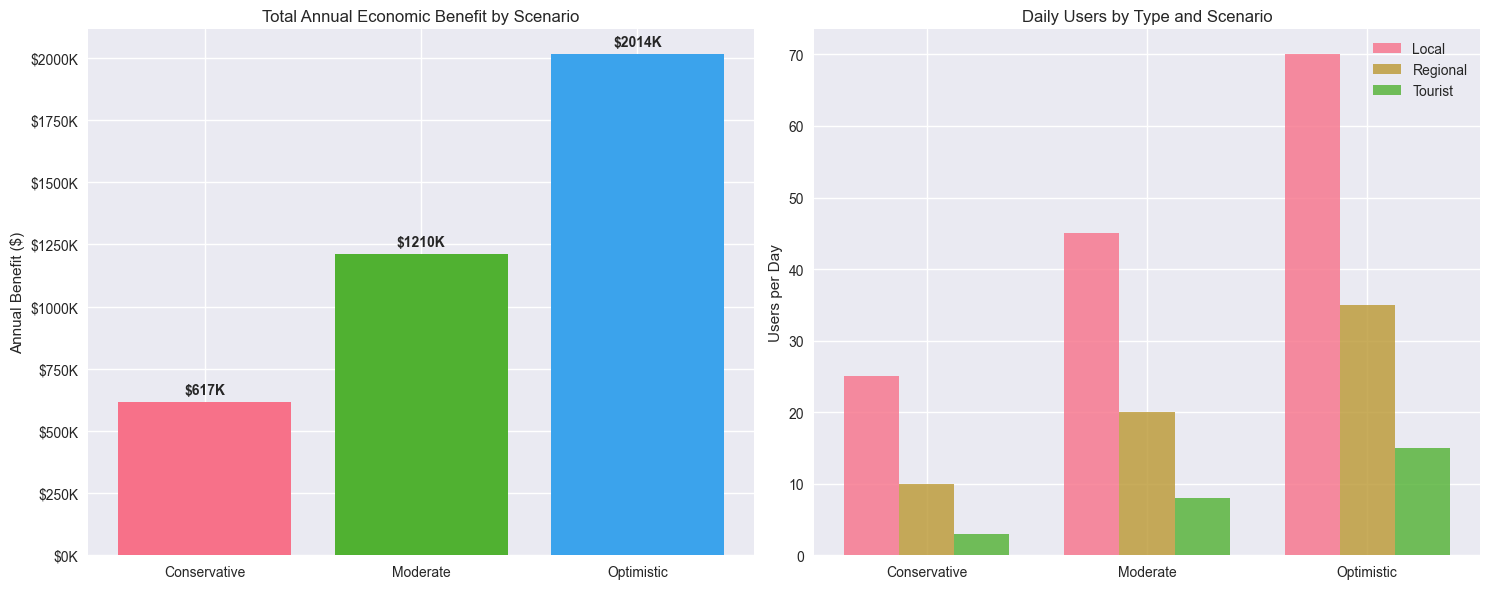

In [ ]:
# Visualize economic impact comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

scenarios_list = list(impact_results.keys())
colors = sns.color_palette("husl", 3)

# Annual benefits by scenario
annual_benefits = [impact_results[s]['annual_benefit'] for s in scenarios_list]
bars1 = ax1.bar(scenarios_list, annual_benefits, color=colors)
ax1.set_title('Total Annual Economic Benefit by Scenario')
ax1.set_ylabel('Annual Benefit ($)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add value labels
for bar, value in zip(bars1, annual_benefits):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(annual_benefits)*0.01,
             f'${value/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Daily users by scenario and type
user_types = ['Local', 'Regional', 'Tourist']
x_pos = np.arange(len(scenarios_list))
width = 0.25

for i, user_type in enumerate(user_types):
    values = [scenarios[s][user_type] for s in scenarios_list]
    ax2.bar(x_pos + i*width, values, width, label=user_type, alpha=0.8)

ax2.set_title('Daily Users by Type and Scenario')
ax2.set_ylabel('Users per Day')
ax2.set_xticks(x_pos + width)
ax2.set_xticklabels(scenarios_list)
ax2.legend()

plt.tight_layout()
plt.show()
